In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project-X-Lip-Reading

/content/drive/.shortcut-targets-by-id/1_r1ryXDRaCdsR0PFGkkxkbeXFIv5d38H/Project-X-Lip-Reading


In [33]:
import numpy as np
import os
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
import imageio
from imutils import face_utils

In [34]:
words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']

In [35]:
get_ipython().run_line_magic('pwd', '')

'/content/drive/.shortcut-targets-by-id/1_r1ryXDRaCdsR0PFGkkxkbeXFIv5d38H/Project-X-Lip-Reading'

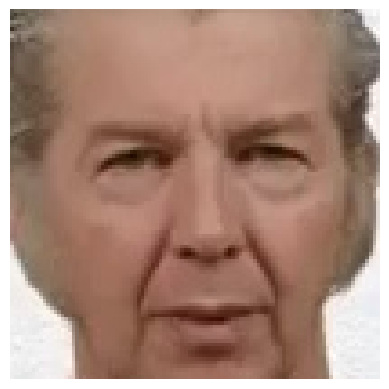

In [36]:
def face_extractor(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    face_classifier = cv2.CascadeClassifier('/content/drive/MyDrive/Project-X-Lip-Reading/Dataset Preprocessing/xml files/haarcascade_frontalface_default.xml')
    faces = face_classifier.detectMultiScale(image, 1.3, 5)

    # If faces are found, extract the first face
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            cropped_image = image[y:y+h, x:x+w]
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
            return cropped_image
    else:
        print("No face found.")
        return None

image = cv2.imread('/content/drive/MyDrive/Project-X-Lip-Reading/Dataset/check.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cropped_image = face_extractor(image)
cv2.imwrite('/content/drive/MyDrive/Project-X-Lip-Reading/Dataset/cropface.jpg', cropped_image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

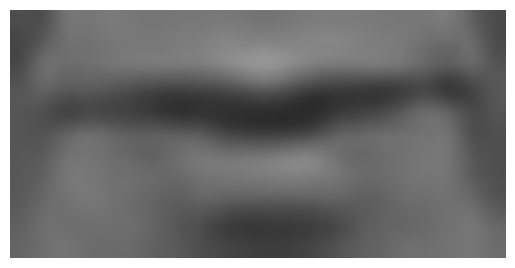

In [37]:
def lips_extractor(img):
    predictor = dlib.shape_predictor('/content/drive/MyDrive/Project-X-Lip-Reading/Dataset Preprocessing/xml files/shape_predictor_68_face_landmarks.dat')

    image = imutils.resize(img, width=56)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    bbox = dlib.rectangle(0, 0, gray.shape[1], gray.shape[0])
    face_landmarks = predictor(gray, bbox)
    face_landmarks = face_utils.shape_to_np(face_landmarks)

    for (name,(i,j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
         if name=='mouth':
            for (x, y) in face_landmarks[i:j]:
                (x, y, w, h) = cv2.boundingRect(np.array([face_landmarks[i:j]]))
                lip_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
                lip_image = imutils.resize(lip_image, width=500, inter=cv2.INTER_CUBIC)

                lip_image = cv2.cvtColor(lip_image, cv2.COLOR_BGR2GRAY)

    if len(lip_image) == 0:
        print("No lips detected.")
        return None
    else:
        return lip_image
image = cv2.imread('/content/drive/MyDrive/Project-X-Lip-Reading/Dataset/cropface.jpg')
cropped_image = lips_extractor(image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2RGB))
plt.axis('off')
plt.show()

In [38]:
# Sequence of image
frames = []
# Path to the video file
video_path = '/content/drive/MyDrive/Project-X-Lip-Reading/Dataset/begin.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define the minimum and maximum number of frames to extract
min_frames = 8
max_frames = 28

# Determine the number of frames to extract based on the video length
num_frames = min(max_frames, max(min_frames, total_frames // 10))

# Calculate the interval between frames
interval = total_frames // num_frames

frames = []
for i in range(num_frames):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
    ret, frame = cap.read()
    if ret:
        frame = face_extractor(frame)
        frame = lips_extractor(frame)
        frame = resize(frame, (100, 100))
        frame = 255 * frame

        frame = frame.astype(np.uint8)
        frames.append(frame)
    else:
        print(f"Error: Could not read frame {i * interval}")

cap.release()
print(f"Extracted {len(frames)} frames.")

pad_array = [np.zeros((100, 100))]
frames.extend(pad_array * (28 - len(frames)))
frames = np.array(frames)


Extracted 8 frames.


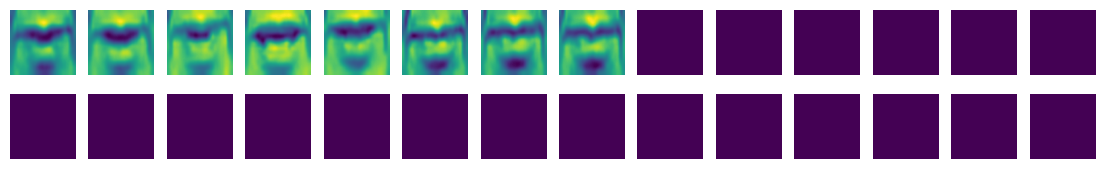

In [39]:
def display_images(image_list):
    fig, axes = plt.subplots(2, 14, figsize=(14, 2))
    for i, img in enumerate(image_list):
        row, col = divmod(i, 14)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  # Hide axes
    plt.show()

display_images(frames)

In [40]:
frames.shape

(28, 100, 100)

In [42]:
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Project-X-Lip-Reading/Model Architecture/Saved Model/3D_CNN_LSTM.h5')

In [46]:
# Normalize the frames
np.seterr(divide='ignore', invalid='ignore')  # Ignore divide by 0 warning
v_min = frames.min(axis=(1, 2), keepdims=True)
v_max = frames.max(axis=(1, 2), keepdims=True)
frames = (frames - v_min) / (v_max - v_min)
frames = np.nan_to_num(frames)

# Reshape the input for prediction
my_pred = frames.reshape(1, 28, 100, 100, 1)
ans = loaded_model.predict(my_pred)

# Get all words with their percentages
percentages = [round(p * 100, 2) for p in ans[0]]
predictions = {words[i]: percentages[i] for i in range(len(words))}

# Print all words with their percentages
for word, percent in predictions.items():
    print(f"Predicted: {word} , {percent} %")

# If you still want to display the word with the maximum percentage
max_index = np.argmax(ans)
text = f"Predicted: {words[max_index]} , {percentages[max_index]} %"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted: Begin , 0.0 %
Predicted: Choose , 0.96 %
Predicted: Connection , 70.57 %
Predicted: Navigation , 1.91 %
Predicted: Next , 0.37 %
Predicted: Previous , 2.23 %
Predicted: Start , 0.4 %
Predicted: Stop , 0.06 %
Predicted: Hello , 3.77 %
Predicted: Web , 0.5 %


In [47]:
print(text)

Predicted: Connection , 70.57 %
